In [8]:
import os
import mlflow

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, TargetEncoder, LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report

# 3. Загрузка очищенной выборки. Разбиение ее на тестовую и обучающую в пропорции 25%-75%

In [9]:
df = pd.read_pickle('../data/clean_data.pkl')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        4521 non-null   uint8   
 1   job        4521 non-null   category
 2   marital    4521 non-null   category
 3   education  4521 non-null   category
 4   default    4521 non-null   category
 5   balance    4521 non-null   float32 
 6   housing    4521 non-null   category
 7   loan       4521 non-null   category
 8   contact    4521 non-null   category
 9   day        4521 non-null   uint32  
 10  month      4521 non-null   category
 11  duration   4521 non-null   uint32  
 12  campaign   4521 non-null   category
 13  y          4521 non-null   category
dtypes: category(10), float32(1), uint32(2), uint8(1)
memory usage: 102.3 KB


In [10]:
df = df.rename(columns={'y': 'target'})

In [11]:
lb = LabelEncoder() 
df['target'] = lb.fit_transform(df['target'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=123)

In [13]:
X_test.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign
2982,38,technician,married,tertiary,no,1161.0,yes,no,unknown,8,may,665,1
276,35,housemaid,married,tertiary,no,11219.0,no,no,cellular,12,aug,699,2
4132,37,technician,married,secondary,no,1063.0,yes,no,cellular,31,jul,413,2
511,32,management,married,tertiary,no,820.0,yes,no,cellular,17,jul,738,3
2061,31,services,married,secondary,no,-331.0,yes,no,unknown,23,may,203,5


# 4. Создание переменных содержащих названия столбцов с числовыми и категориальными признаками

In [14]:
num_features = list(df.select_dtypes(include=['number']).columns)
num_features.remove("target")
num_features


['age', 'balance', 'day', 'duration']

In [15]:
cat_features = list(df.select_dtypes(include=['category']).columns)
cat_features


['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'campaign']

# 5. Создание pipeline обработки признаков и обучения модели. 
Для числовых признаков использую StandardScaler, для категориальных - TargetEncoder(для задачи классификации) 
В качестве модели - RandomForest


In [16]:
s_scaler = StandardScaler()
t_encoder = TargetEncoder()
classifier = RandomForestClassifier(n_estimators=300, max_depth=50)

In [17]:
# Для удобной работы со столбцами
preprocessor = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', t_encoder, cat_features), # преобразования для категориальных признаков
    ],
    remainder='drop' ) # Удаляем столбцы, которые не затронуты преобразования

In [18]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                           ('model', classifier)])



# 6. Обучение baseline-модели и получение метрики качества на тестовой выборке. 
Для задачи классификации это precision, recall, f1, roc_auc.

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration']),
                                                 ('cat', TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'campaign'])])),
                ('model',
                 RandomForestClassifier(max_depth=50, n_estimators=300))])

In [20]:
predictions = pipeline.predict(X_test) 
predictions


array([0, 0, 0, ..., 0, 0, 0])

In [21]:
metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.2764227642276423,
 'precision': 0.6415094339622641,
 'f1': 0.38636363636363635,
 'roc_auc': 0.628786778939218}

# 9. Логирование baseline-модели в новый эксперимент. Регистрация модели.

In [22]:
# Обязательно логируем сигнатуру модели и пример входных данных. Подготовим их
from mlflow.models import infer_signature

signature =  infer_signature(model_input = X_train.head(5))
input_example = X_train.head(5)

# Будем логировать requirements и артефакт - текстовый файл
req_file = '../requirements.txt'
art = 'comment.txt'

# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
#params_dict = {'n_estimators': 10, 'max_depth': 10}
params_dict = pipeline.get_params()

/home/yuriy/ProgrammingProjects/IIS_labs/.venv_IIS/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [23]:
# Работаем с MLflow локально
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

registry_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"
tracking_uri = f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}"

mlflow.set_tracking_uri(tracking_uri)   
mlflow.set_registry_uri(registry_uri)       

In [24]:
# название тестового эксперимента, запуска (run) внутри него, имени, под которым модель будет регистрироваться
EXPERIMENT_NAME = "estate_project1"
RUN_NAME = "baseline model"
REGISTRY_MODEL_NAME = "estate_model_rf"

# Когда создаем новый эксперимент, то: 
# experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)

# Впоследствии. чтобы добавлять запуски в этот же эксепримент мы должны получить его id:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    # mlflow.log_artifact(art)
    mlflow.log_params(params_dict)

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

/home/yuriy/ProgrammingProjects/IIS_labs/.venv_IIS/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/12/09 14:13:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline model at: http://127.0.0.1:5000/#/experiments/1/runs/957705ff81624b07a390aa72f0a5d651.
2024/12/09 14:13:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


# 10. С использованием библиотеки sklearn создание дополнительных признаки, обучение модель, ее логирование.

In [25]:
from sklearn.preprocessing import QuantileTransformer, SplineTransformer, PolynomialFeatures, MinMaxScaler, KBinsDiscretizer

1. Создайте новую переменную X_train_fe_sklearn- копию исходной обучающей выборки, используя метод .copy() датафрейма

In [26]:
X_train_fe_sklearn = X_train.copy()
Y_train_fe_sklearn = y_train.copy()

2. Создайте ColumnTransformer, содержащий как трансформации baseline-модели (сделанные в п.5 ЛР), так и новые.

In [27]:
pf = PolynomialFeatures(degree=2)
qt = QuantileTransformer()
kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

In [28]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', t_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,["balance"]),
        ('poly', Pipeline(steps=[
                                    ('poly', pf),
                                    ('scale', StandardScaler())
                                ]), ["age", "balance"]
            ), # В преобразования добавляем созданный ранее pipeline
        ('kbins', kb, num_features),
    ],
    remainder='drop') # Удаляем столбцы, которые не затронуты преобразования


3. Обучите и сохраните в переменную X_train_fe_sklearn (используя метод fit_transform) получившиеся преобразования.

In [29]:
X_train_fe_sklearn_raw = preprocessor_sklearn.fit_transform(X_train_fe_sklearn, Y_train_fe_sklearn)
X_train_fe_sklearn = pd.DataFrame(X_train_fe_sklearn_raw, columns=preprocessor_sklearn.get_feature_names_out())

4. Сохраните в файл названия столбцов получившегося датафрейма. Этот файл нужно будет залогировать в MLFlow

In [30]:
X_train_fe_sklearn.columns

Index(['num__age', 'num__balance', 'num__day', 'num__duration', 'cat__job',
       'cat__marital', 'cat__education', 'cat__default', 'cat__housing',
       'cat__loan', 'cat__contact', 'cat__month', 'cat__campaign',
       'quantile__balance', 'poly__1', 'poly__age', 'poly__balance',
       'poly__age^2', 'poly__age balance', 'poly__balance^2', 'kbins__age',
       'kbins__balance', 'kbins__day', 'kbins__duration'],
      dtype='object')

In [31]:
with open("column_names.txt", "w") as output:
    output.write(str(X_train_fe_sklearn.columns))

5. Создайте pipeline, в котором на первом шаге будет работать ColumnTransformer, созданный в этом пункте, а на втором - модель

In [32]:
pipeline_sklearn = Pipeline(steps=[('preprocessor', preprocessor_sklearn), 
                           ('model', classifier)])

In [33]:
pipeline_sklearn.fit(X_train, y_train)

predictions = pipeline_sklearn.predict(X_test) 
metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics


{'recall': 0.24390243902439024,
 'precision': 0.5882352941176471,
 'f1': 0.3448275862068966,
 'roc_auc': 0.6115345528455285}

In [34]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'fe_sklearn'

input_example = X_train_fe_sklearn.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = pipeline_sklearn.get_params()

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(pipeline_sklearn, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('column_names.txt', artifact_path = 'Фичи')
    mlflow.log_params(pipeline_sklearn.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/09 14:13:57 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__age",
      "num__balance",
      "num__day",
      "num__duration",
      "cat__job",
      "cat__marital",
      "cat__education",
      "cat__default",
      "cat__housing",
      "cat__loan",
      "cat__contact",
      "cat__month",
      "cat__campaign",
      "quantile__balance",
      "poly__1",
      "poly__age",
      "poly__balance",
      "poly__age^2",
      "poly__age balance",
      "poly__balance^2",
      "kbins__age",
      "kbins__balance",
      "kbins__day",
      "kbins__duration"
    ],
    "data": [
      [
        -0.8761525926346357,
        -0.4302728449277611,
        0.3877878384311291,
        -0.2868751456737427,
        0.0740588453965768,
        0.10119887487276065,
        0.10508047936878315,
        0.1178448968133795,
        0.08997495312464684,
        0.1262934109626426,
        0.042784249526045516,
   

# 12.С использованием библиотеки mlxtend отобрать N наиболее важных признаков. 
N выбирается с учетом количества признаков на предыдущем шаге, ориентировочный диапазон - от 20% до 70%. Обучить модель, залогировать ее.

В ЛР отбор будем проводить для признаков, полученных трансформациями sklearn в пункте 10. Алгоритм выполнения пункта следующий:



1. Создайте SequentialFeatureSelector c направлением последовательным добавлением признаков (forward).


In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector 

In [40]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=100, n_jobs=-1), 
                                k_features="best",
                                forward=True,
                                floating=False, # True to drop selected features
                                scoring='roc_auc',
                                n_jobs=-1,
                                verbose=2,
                                cv=3)



2. В пункте 10 был получен датафреймX_train_fe_sklearn, состоящий из расширенного набора признаков по сравнению с исходными данными. На этом датафрейме обучите SequentialFeatureSelector.

In [41]:
sfs.fit(X_train_fe_sklearn,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:    8.8s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    8.9s finished

[2024-12-09 14:19:05] Features: 1/24 -- score: 0.6926474549183806[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    6.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    6.8s finished

[2024-12-09 14:19:12] Features: 2/24 -- score: 0.8002259785616198[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    6.3s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    6.4s finished

[2024-12-09 14:19:19] Features: 3/24 -- score: 0.8502491427378577[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21

SequentialFeatureSelector(cv=3, estimator=RandomForestClassifier(n_jobs=-1),
                          k_features=(1, 24), n_jobs=-1, scoring='roc_auc',
                          verbose=2)

3. Выведите на экран и сохраните в файлы названия отобранных столбцов и их индексы (их нужно будет залогировать вместе с моделью)

In [42]:
selected_features_sfs = X_train_fe_sklearn.loc[:, sfs.k_feature_names_]
selected_features_sfs

,num__day,num__duration,cat__housing,cat__loan,cat__contact,cat__month,poly__1,poly__age^2
0,0.387788,-0.286875,0.089975,0.126293,0.042784,0.069497,0.0,-0.819394
1,1.480859,-0.551255,0.152764,0.126293,0.146169,0.109679,0.0,0.122207
2,0.630693,-0.379008,0.157537,0.127792,0.154400,0.107728,0.0,1.134015
3,-1.676903,-0.018489,0.152764,0.126293,0.146169,0.173074,0.0,-0.884439
4,0.144883,0.346035,0.092991,0.067240,0.144300,0.103786,0.0,-0.463196
...,...,...,...,...,...,...,...,...
3385,-0.826736,-0.310910,0.087141,0.127792,0.146869,0.098080,0.0,0.704513
3386,-1.069641,-0.463129,0.156787,0.129994,0.145991,0.084367,0.0,-0.683110
3387,-0.340927,-0.306904,0.086516,0.129994,0.145991,0.160595,0.0,-0.683110
3388,0.023431,-0.234800,0.092991,0.126403,0.044968,0.071799,0.0,1.717354


In [43]:
rfe_sfs_idx = list(sfs.k_feature_idx_)
rfe_sfs_idx
rfe_sfs_col = list(sfs.k_feature_names_)
rfe_sfs_col

['num__day',
 'num__duration',
 'cat__housing',
 'cat__loan',
 'cat__contact',
 'cat__month',
 'poly__1',
 'poly__age^2']

In [44]:
with open("rfe_sfs_cols.txt", "w") as output:
    output.write(str(rfe_sfs_col))
with open("rfe_sfs_idx.txt", "w") as output:
    output.write(str(rfe_sfs_idx))

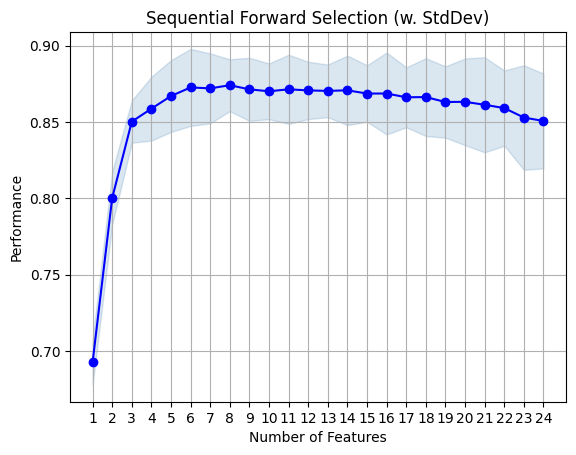

In [45]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

4. Добавьте в папйлайн из пункта 10 вторым шагом отбор столбцов в соответствии с заданными индексами

In [46]:
class ColumnExtractor(object):

    def __init__(self, cols):
        self.cols = cols

    def transform(self, X):
        return X[:,self.cols]
    
    def fit(self, X, y=None):
        return self

In [47]:
rfe_sfs_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', classifier)
])

rfe_sfs_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration']),
                                                 ('cat', TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'campaign']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['balance']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'balance']),
                                                 ('kbins',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x75a159d56e10>),
                ('model',
                 RandomForestClassifier(max_depth=50, n_estimators=300))])

In [48]:

predictions_sfs = rfe_sfs_pipeline.predict(X_test) 
metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.24390243902439024,
 'precision': 0.5882352941176471,
 'f1': 0.3448275862068966,
 'roc_auc': 0.6115345528455285}

In [49]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'rfe_sfs_feature_selection'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(rfe_sfs_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_artifact('rfe_sfs_cols.txt')
    mlflow.log_artifact('rfe_sfs_idx.txt')
    mlflow.log_params(rfe_sfs_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/09 14:20:57 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__age",
      "num__balance",
      "num__day",
      "num__duration",
      "cat__job",
      "cat__marital",
      "cat__education",
      "cat__default",
      "cat__housing",
      "cat__loan",
      "cat__contact",
      "cat__month",
      "cat__campaign",
      "quantile__balance",
      "poly__1",
      "poly__age",
      "poly__balance",
      "poly__age^2",
      "poly__age balance",
      "poly__balance^2",
      "kbins__age",
      "kbins__balance",
      "kbins__day",
      "kbins__duration"
    ],
    "data": [
      [
        -0.8761525926346357,
        -0.4302728449277611,
        0.3877878384311291,
        -0.2868751456737427,
        0.0740588453965768,
        0.10119887487276065,
        0.10508047936878315,
        0.1178448968133795,
        0.08997495312464684,
        0.1262934109626426,
        0.042784249526045516,
   

# 14. С помощью optuna настроить оптимальные параметры для модели, показывающей лучший результат. Обучить модель, залогировать ее, зарегистрировать очередную версию.

У Random Forest будем настраивать параметры:

количество деревьев
глубина дерева
max_features в интервале от 0.1 до 1.0
Проведите не менее 10 trails по подбору опитмальных гиперпараметров. Настраивать качество будем по метрике mae для регрессии и f1 для классификации. Обратите внимание и явно укажите в коде на то, что нужно делать с метрикой - максимизировать или минимизировать.

Обученную модель залогируйте в MLFlow. Не забудьте поменять RUN_NAME на понятный, соответствующий действиям в этом пункте ЛР.

Зарегистрируйте модель в качестве второй версии исходной модели. Можно через интерфейс, можно с использованием API.

In [50]:
import optuna

In [51]:
def objective(trial):
    # предлагаем гиперпараметры
    n_estimators = trial.suggest_int('n_estimators', 1, 200)
    max_depth = trial.suggest_int('max_depth', 1, 200)
    max_features = trial.suggest_float('max_features', 0.1, 1)

    # создаём и обучаем модель
    opt_pipeline  = Pipeline(steps=[
        ('preprocessor', preprocessor_sklearn), 
        ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
        ('model', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features))
    ])

    opt_pipeline.fit(X_train, y_train)

    # предсказываем и вычисляем RMSE
    preds = opt_pipeline.predict(X_test)
    f1 =  f1_score(y_test, preds)   

    return f1

In [52]:
# Запускаем оптимизацию
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

# Выводим лучшие гиперпараметры
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-12-09 14:20:57,321] A new study created in memory with name: no-name-f5194b5b-2d97-40f6-9bfb-1ce7546a0a80
[I 2024-12-09 14:20:58,204] Trial 0 finished with value: 0.49038461538461536 and parameters: {'n_estimators': 97, 'max_depth': 99, 'max_features': 0.5569055705648948}. Best is trial 0 with value: 0.49038461538461536.
[I 2024-12-09 14:20:59,615] Trial 1 finished with value: 0.4803921568627451 and parameters: {'n_estimators': 141, 'max_depth': 54, 'max_features': 0.7109772229467961}. Best is trial 0 with value: 0.49038461538461536.
[I 2024-12-09 14:21:00,105] Trial 2 finished with value: 0.34285714285714286 and parameters: {'n_estimators': 92, 'max_depth': 28, 'max_features': 0.1371431416406071}. Best is trial 0 with value: 0.49038461538461536.
[I 2024-12-09 14:21:00,753] Trial 3 finished with value: 0.28402366863905326 and parameters: {'n_estimators': 127, 'max_depth': 30, 'max_features': 0.1962770160688142}. Best is trial 0 with value: 0.49038461538461536.
[I 2024-12-09 14:

Number of finished trials: 60
Best trial: {'n_estimators': 175, 'max_depth': 114, 'max_features': 0.6242940624947486}


In [53]:
best_params = study.best_trial.params
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier(**best_params))
])

opt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration']),
                                                 ('cat', TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'campaign']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['balance']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'balance']),
                                                 ('kbins',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x75a159a551f0>),
                ('model',
                 RandomForestClassifier(max_depth=114,
                                        max_features=0.6242940624947486,
                                        n_estimators=175))])

In [54]:
predictions = opt_pipeline.predict(X_test)

metrics = {}
metrics["recall"] = recall_score(y_test, predictions)   
metrics["precision"] = precision_score(y_test, predictions)
metrics["f1"] = f1_score(y_test, predictions)
metrics["roc_auc"] = roc_auc_score(y_test, predictions)
metrics

{'recall': 0.43089430894308944,
 'precision': 0.5888888888888889,
 'f1': 0.49765258215962443,
 'roc_auc': 0.6970939798683702}

In [55]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'optuna_model'

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_metrics(metrics)
    mlflow.log_params(opt_pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/09 14:22:10 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__age",
      "num__balance",
      "num__day",
      "num__duration",
      "cat__job",
      "cat__marital",
      "cat__education",
      "cat__default",
      "cat__housing",
      "cat__loan",
      "cat__contact",
      "cat__month",
      "cat__campaign",
      "quantile__balance",
      "poly__1",
      "poly__age",
      "poly__balance",
      "poly__age^2",
      "poly__age balance",
      "poly__balance^2",
      "kbins__age",
      "kbins__balance",
      "kbins__day",
      "kbins__duration"
    ],
    "data": [
      [
        -0.8761525926346357,
        -0.4302728449277611,
        0.3877878384311291,
        -0.2868751456737427,
        0.0740588453965768,
        0.10119887487276065,
        0.10508047936878315,
        0.1178448968133795,
        0.08997495312464684,
        0.1262934109626426,
        0.042784249526045516,
   

16. Проанализировать все прогоны и выбрать модель, показывающую наилучшее качество. 

Обучить эту модель на всей выборке (а не только на train-части), залогировать ее. В реестре моделей установить ей тэг Production. Эту модель мы будем деплоить в следующей лабораторной работе.

In [56]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [57]:
X_train_fe_sklearn = X_full.copy()

In [58]:
preprocessor_sklearn = ColumnTransformer(
    transformers=[
        ('num', s_scaler, num_features),  # преобразования для числовых признаков
        ('cat', t_encoder, cat_features), # преобразования для категориальных признаков
        ('quantile', qt,["balance"]),
        ('poly', Pipeline(steps=[
                                    ('poly', pf),
                                    ('scale', StandardScaler())
                                ]), ["age", "balance"]
            ), # В преобразования добавляем созданный ранее pipeline
        ('kbins', kb, num_features),
    ],
    remainder='drop') # Удаляем столбцы, которые не затронуты преобразования

X_train_sklearn = preprocessor_sklearn.fit_transform(X_train_fe_sklearn, y_full)
X_train_sklearn_df = pd.DataFrame(X_train_sklearn, columns = preprocessor_sklearn.get_feature_names_out())

In [59]:
opt_pipeline  = Pipeline(steps=[
    ('preprocessor', preprocessor_sklearn), 
    ('rfe_extractor', ColumnExtractor(rfe_sfs_idx)),
    ('model', RandomForestClassifier(**best_params))
])

opt_pipeline.fit(X_full, y_full)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration']),
                                                 ('cat', TargetEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'campaign']),
                                                 ('quantile',
                                                  QuantileTransformer(),
                                                  ['balance']),
                                                 ('poly',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['age', 'balance']),
                                                 ('kbins',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   strategy='uniform'),
                                                  ['age', 'balance', 'day',
                                                   'duration'])])),
                ('rfe_extractor',
                 <__main__.ColumnExtractor object at 0x75a159d78380>),
                ('model',
                 RandomForestClassifier(max_depth=114,
                                        max_features=0.6242940624947486,
                                        n_estimators=175))])

In [60]:
predictions = opt_pipeline.predict(X_test)

In [61]:
col_names = preprocessor_sklearn.get_feature_names_out()
with open("column_names_best_model.txt", "w") as output:
    output.write(str(col_names))

In [62]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = 'best_model'

input_example = X_train_sklearn_df.head(5)

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
# Параметры, котороые будут залогированы, можем задавать вручную или полностью взять из модели
params_dict = opt_pipeline.get_params()

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    # получаем уникальный идентификатор запуска эксперимента
    run_id = run.info.run_id 
    mlflow.sklearn.log_model(opt_pipeline, 
                             artifact_path="models",
                             signature=signature,
                             input_example=input_example,
                             pip_requirements=req_file
                             )
    mlflow.log_artifact('column_names_best_model.txt', artifact_path = 'columns')
    mlflow.log_params(pipeline.get_params())

run = mlflow.get_run(run_id) 
assert (run.info.status =='FINISHED')

2024/12/09 14:22:13 WARNING mlflow.models.model: Failed to validate serving input example {
  "dataframe_split": {
    "columns": [
      "num__age",
      "num__balance",
      "num__day",
      "num__duration",
      "cat__job",
      "cat__marital",
      "cat__education",
      "cat__default",
      "cat__housing",
      "cat__loan",
      "cat__contact",
      "cat__month",
      "cat__campaign",
      "quantile__balance",
      "poly__1",
      "poly__age",
      "poly__balance",
      "poly__age^2",
      "poly__age balance",
      "poly__balance^2",
      "kbins__age",
      "kbins__balance",
      "kbins__day",
      "kbins__duration"
    ],
    "data": [
      [
        -0.8671450940660096,
        -0.4391903443194925,
        0.3740520633526504,
        -0.28080623344336664,
        0.08090508068935533,
        0.10139009140426715,
        0.10660611870561618,
        0.11473581293321176,
        0.08639451309236507,
        0.12479410743762073,
        0.04497152798042389,
